# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорты

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer

from lightgbm.sklearn import LGBMRegressor

/usr/lib/python3/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _

### Загрузка и общий анализ данных

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('% пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

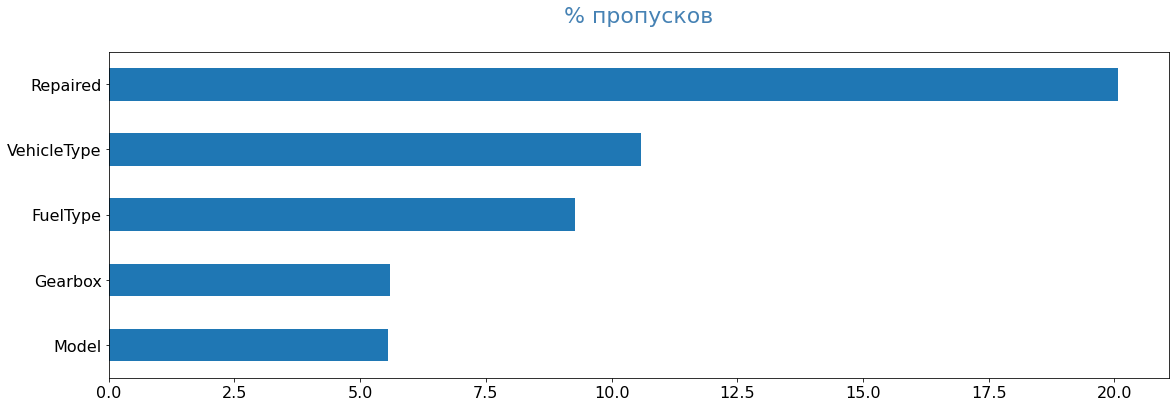

In [6]:
pass_value_barh(df)

**Описание столбцов:**

Признаки:  
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:  
- Price — цена (евро)

Данные загружены. Явные пропуски есть в 5 столбцах. Столбцы, где есть проруски категориальные.

### Полные дубликаты строк

In [7]:
df.duplicated().sum()

4

Всего лучше удалить, но сперва запомним количество объектов, чтобы потом отследить какой % мы потеряли из за обработки.

In [8]:
INIT_SIZE = len(df)
INIT_SIZE

354369

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

### Обработка и анализ количественных признаков

In [10]:
num_features = []

#### Цена

Пропусков нет. Построим гистограмму, ящик с усами и посчитаем меры описательной статистики.

In [11]:
def hist_box(series, num_bins=10, max_lim=None):
    fig, ax = plt.subplots(1, 2,figsize=(20, 10));
    ax[0].set_xlabel(series.name);
    ax[0].set_ylabel("Count");
    series.hist(bins=num_bins, ax=ax[0]);
    series.plot(kind='box', fontsize=16, ax=ax[1]);
    fig.tight_layout()

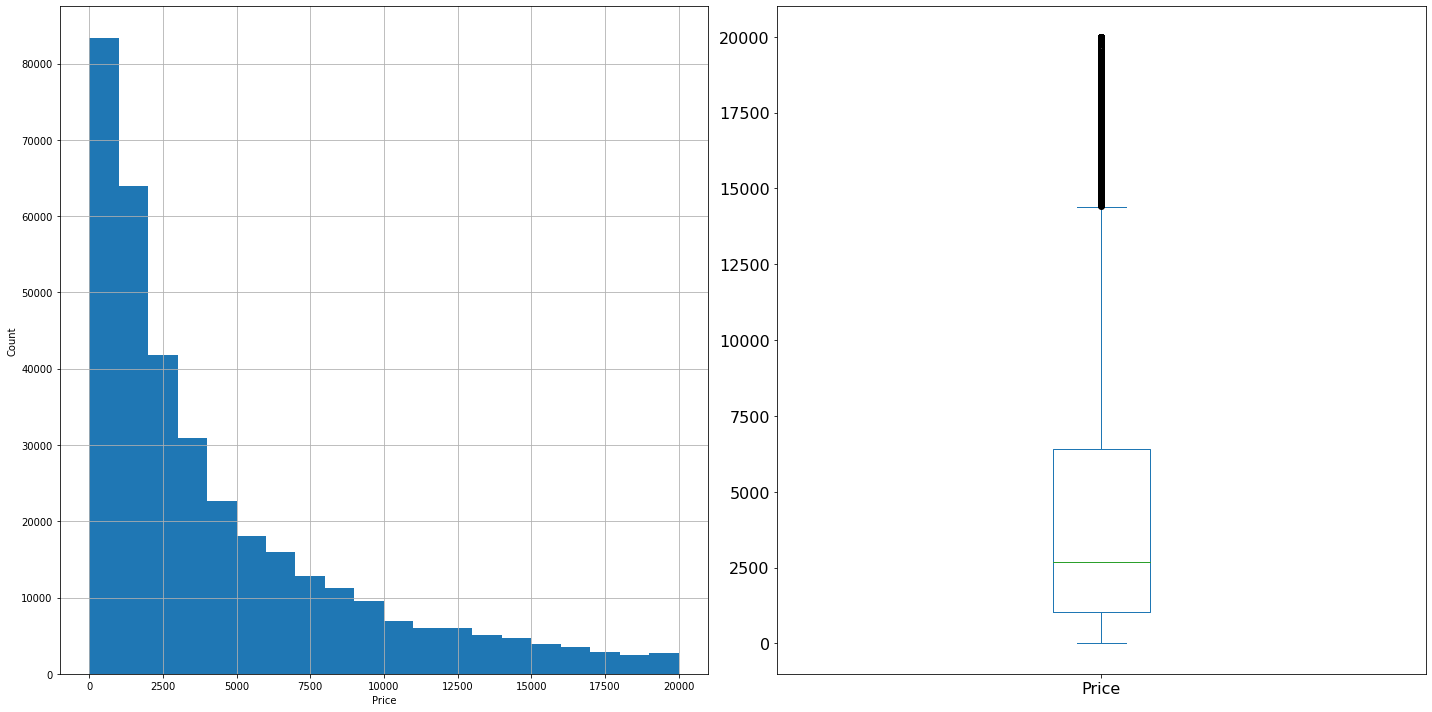

In [12]:
hist_box(df.Price, 20)

По боксплоту выбросы с верхней стороны есть однако они вполне разумны и не заоблачные. Посмотрим, что внизу. Но сперва, описательная статистика:

In [13]:
df.Price.describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Машина за 0 евро: не битая, не крашенная, даром! Всё таки снизу надо выправлять ситуацию. Сперва выберем границу в 5% самых дешёвых автомобилей.

In [14]:
df.Price.quantile(0.05)

200.0

Двести евро - дешёво даже для сильно подержанных машин, но остановимся на этом и отфильтруем, всё, что ниже.

In [15]:
df = df[df.Price >= df.Price.quantile(0.05)]

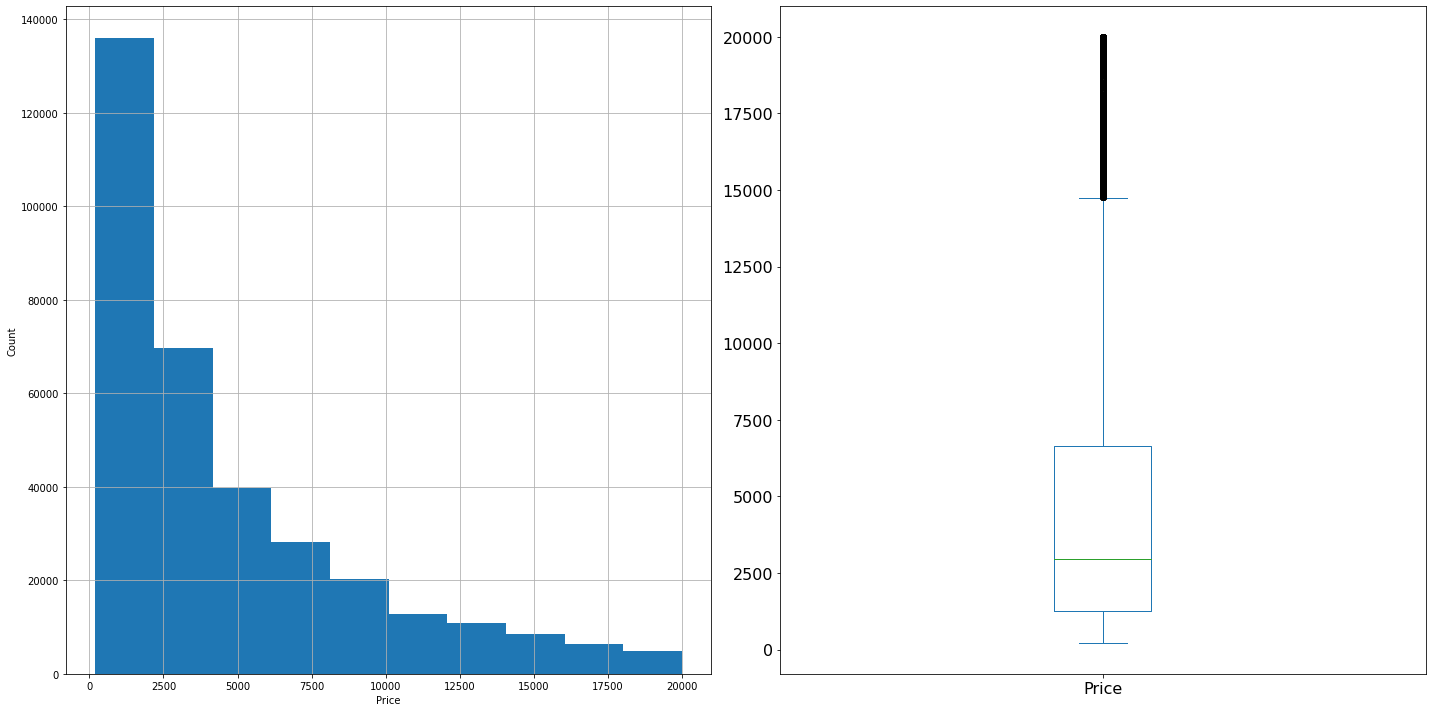

In [16]:
hist_box(df.Price)

In [17]:
df.Price.describe()

count    336903.000000
mean       4643.642063
std        4515.355328
min         200.000000
25%        1250.000000
50%        2950.000000
75%        6650.000000
max       20000.000000
Name: Price, dtype: float64

#### Мощность

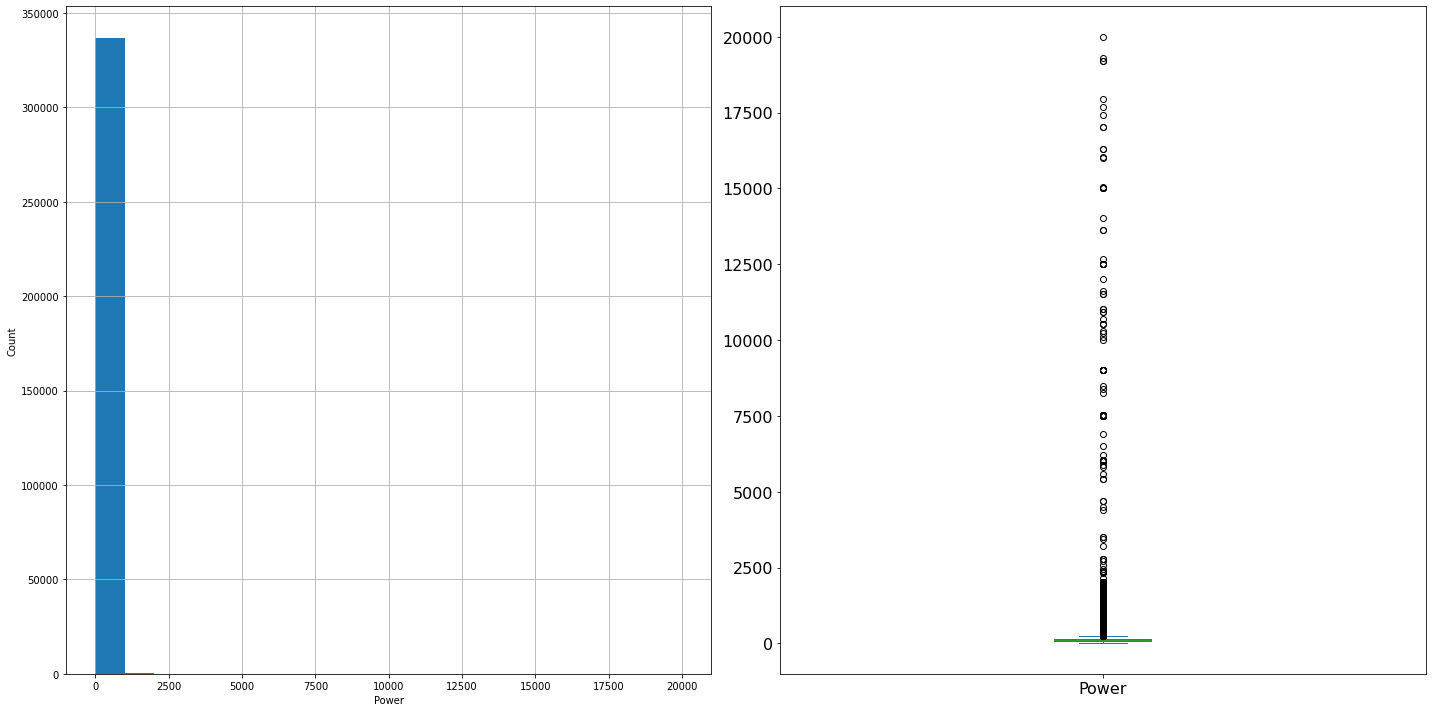

In [18]:
hist_box(df.Power, 20)

In [19]:
df.Power.describe()

count    336903.000000
mean        112.111789
std         188.016230
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Аномалии и снизу и сверху. 0 л.с. - видимо веломобили, а 20000 - тепловозы и корабли. Сперва разберемся с тепловозами и пароходами. На сегодняшний день самым мощным легковым автомобилем в мире назван Dagger GT компании TranStar Racing LLC. Только представьте: мощность его двигателя превышает 2000 лошадиных сил (2028 л. с.). Но вообще такие машины редкость и не типичны.
Найдём 99 перцентиль:

In [20]:
df.Power.quantile(0.99)

300.0

Уже более менее соответсвует мощным авто. 

In [21]:
df.sort_values(by="Power", ascending=False).head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
219583,2016-03-09 15:43:53,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,2016-03-09 00:00:00,0,19406,2016-03-30 08:47:08
299177,2016-03-09 08:53:11,1500,wagon,1997,manual,19312,5er,150000,1,NaN,bmw,no,2016-03-09 00:00:00,0,21129,2016-04-07 11:44:34
114106,2016-04-03 07:36:21,9999,sedan,2006,manual,19211,1er,125000,0,gasoline,bmw,NaN,2016-04-03 00:00:00,0,45964,2016-04-07 10:16:10
132485,2016-03-25 14:55:49,2100,wagon,2001,manual,19208,5er,150000,5,NaN,bmw,yes,2016-03-25 00:00:00,0,59556,2016-03-30 05:16:18
63986,2016-03-28 11:49:56,3250,sedan,2001,auto,17932,omega,150000,6,petrol,opel,NaN,2016-03-28 00:00:00,0,86641,2016-04-06 14:17:21
196531,2016-03-20 16:51:48,6000,wagon,2004,auto,17700,5er,150000,7,gasoline,bmw,no,2016-03-20 00:00:00,0,26316,2016-04-06 22:45:56
150676,2016-03-09 18:57:50,1700,wagon,1995,manual,17410,80,5000,0,petrol,audi,yes,2016-03-09 00:00:00,0,23562,2016-03-15 07:17:06
187329,2016-03-17 19:50:23,1749,wagon,1989,manual,17019,3er,5000,12,petrol,bmw,NaN,2016-03-17 00:00:00,0,89542,2016-03-26 00:46:59
175421,2016-03-19 11:38:23,10900,sedan,2007,auto,17011,a3,5000,7,gasoline,audi,NaN,2016-03-19 00:00:00,0,12355,2016-03-21 15:20:06
216992,2016-03-10 08:57:25,11950,convertible,2008,manual,16312,a4,20000,4,petrol,audi,no,2016-03-10 00:00:00,0,51647,2016-03-17 09:16:19


Теперь поработаем с авто с слабосильной силовой установкой, меньше 30 л.с.

In [22]:
100*df[df.Power < 30].shape[0]/df.shape[0]

10.23054113498544

Таких довольно много, но не критично много, чтобы выкинуть их из набора, так как параметр по-логике критичный для цены.

In [23]:
df = df[(30 <= df.Power) & (df.Power <= df.Power.quantile(0.99))]

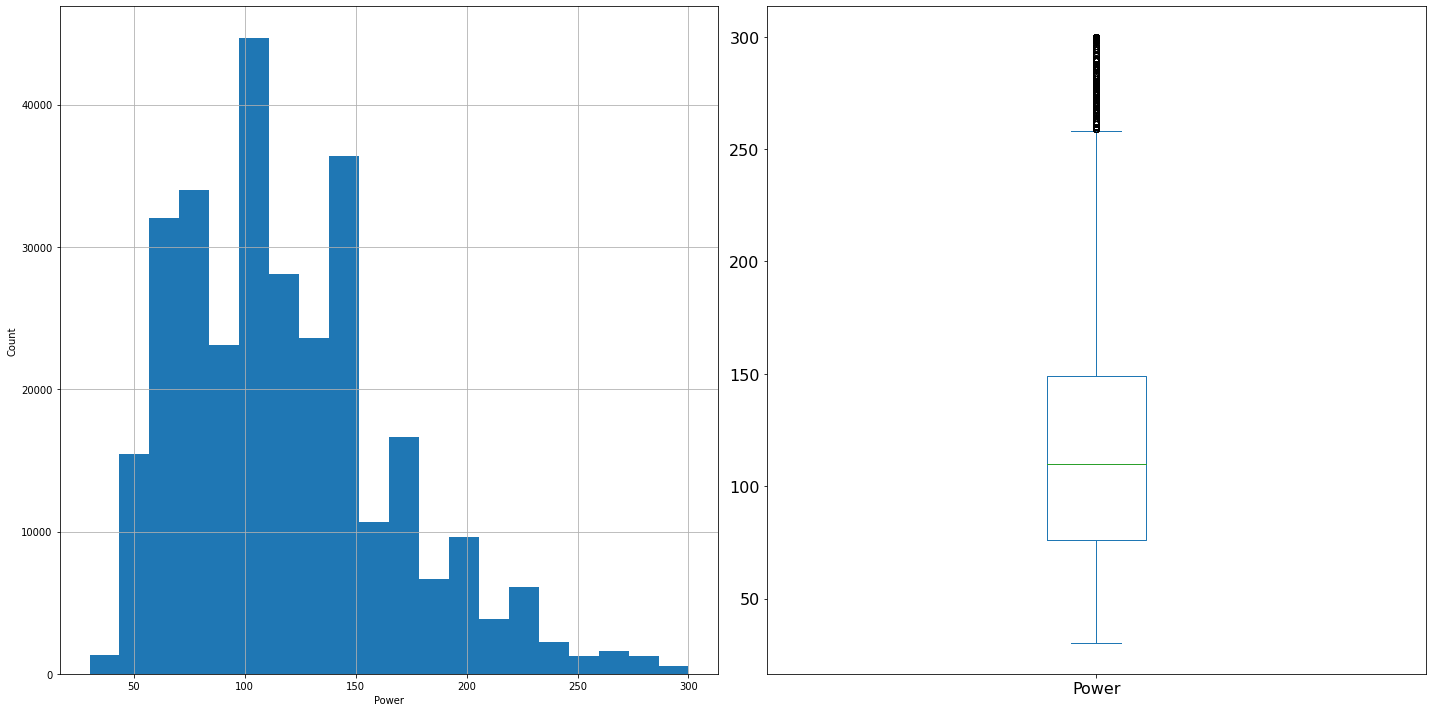

In [24]:
hist_box(df.Power, 20)

In [25]:
df.Power.describe()

count    299068.000000
mean        118.698059
std          48.511826
min          30.000000
25%          76.000000
50%         110.000000
75%         149.000000
max         300.000000
Name: Power, dtype: float64

Привели данные по мощности в какой то порядок.

In [26]:
num_features.append("Power")

#### Год регистрации автомобиля

In [27]:
df.RegistrationYear.describe()

count    299068.000000
mean       2003.567857
std          28.890948
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Тысячный год - это видимо повозка, а 9999 - гравицапа. посмотрим сколько данных лежит в разумных пределах от 1950 до 2022.

In [28]:
100*df[(df.RegistrationYear < 1950) | (df.RegistrationYear > 2022)].shape[0]/df.shape[0]

0.015381117337862961

Очень немного.

In [29]:
df[(df.RegistrationYear < 1950) | (df.RegistrationYear > 2022)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25 00:00:00,0,58135,2016-03-25 15:58:21
16635,2016-03-09 10:54:11,9500,suv,1941,manual,57,NaN,40000,1,petrol,sonstige_autos,no,2016-03-09 00:00:00,0,59557,2016-03-12 21:16:29
18224,2016-03-09 17:49:44,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
22621,2016-03-23 11:37:57,14000,sedan,1929,manual,30,NaN,5000,7,petrol,sonstige_autos,NaN,2016-03-23 00:00:00,0,90475,2016-04-05 11:18:18
23750,2016-03-16 19:58:34,3900,wagon,1910,manual,90,passat,150000,0,petrol,volkswagen,NaN,2016-03-16 00:00:00,0,88662,2016-04-07 05:45:53
27525,2016-03-12 20:54:39,13300,sedan,1949,NaN,99,other,60000,7,petrol,chrysler,NaN,2016-03-12 00:00:00,0,28279,2016-04-05 15:47:32
34055,2016-03-25 00:55:47,2900,small,1937,manual,34,other,40000,7,petrol,ford,yes,2016-03-25 00:00:00,0,33378,2016-04-02 07:16:41
46741,2016-03-12 07:36:23,5000,NaN,2900,manual,120,corsa,5000,9,petrol,opel,NaN,2016-03-12 00:00:00,0,9326,2016-04-05 23:18:26
46935,2016-03-27 06:01:00,4900,NaN,6000,manual,52,NaN,10000,0,petrol,sonstige_autos,no,2016-03-27 00:00:00,0,38259,2016-04-07 04:16:10
53678,2016-03-29 22:39:32,7999,NaN,5911,auto,75,golf,10000,0,NaN,volkswagen,NaN,2016-03-29 00:00:00,0,41462,2016-04-06 09:17:09


Есть действительно рарирететы, которые должны продаваться на специализированных аукционах, а есть просто ошибки. Фильтруем. 

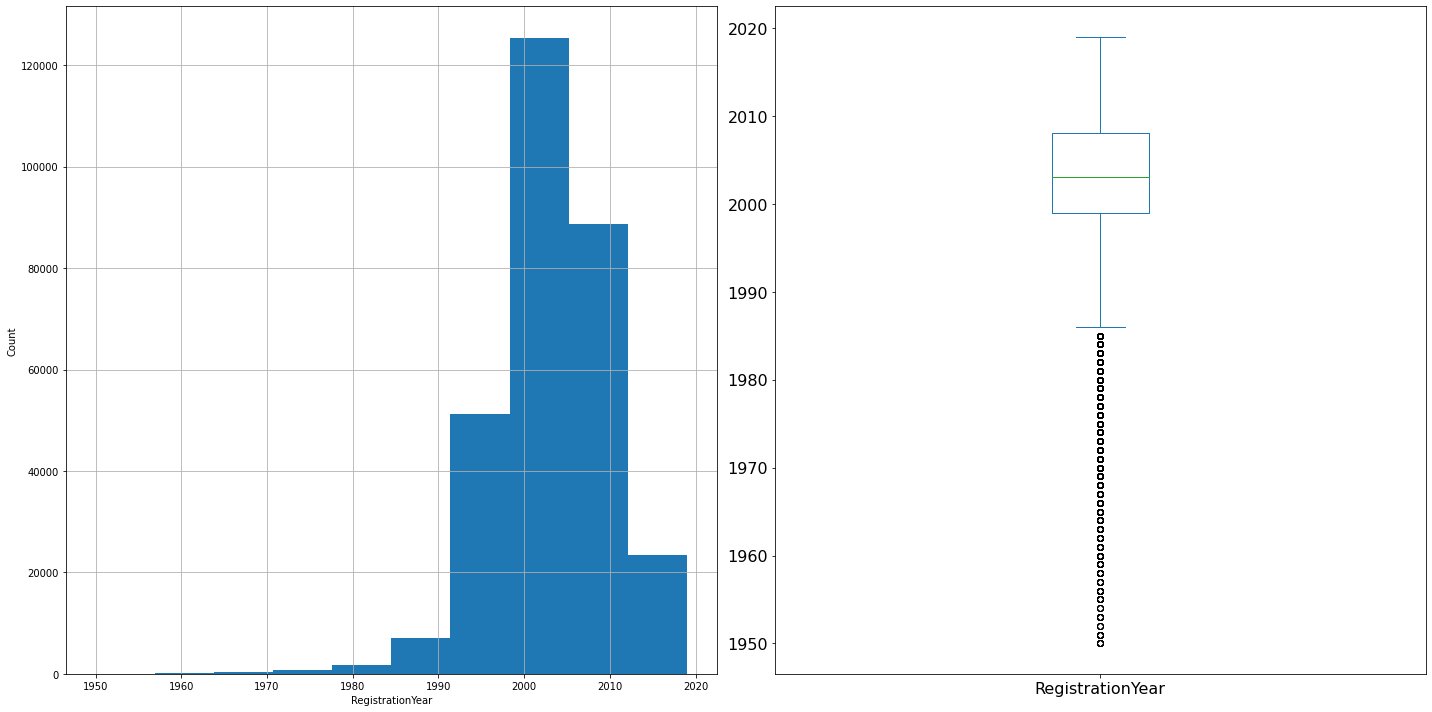

In [30]:
df = df[(df.RegistrationYear >= 1950) & (df.RegistrationYear <= 2022)]
hist_box(df.RegistrationYear)

Выбросы начинаются ниже конца восьмидесятых. Однако ничего страшного я в них не вижу.

In [31]:
df.RegistrationYear.describe()

count    299022.000000
mean       2003.405405
std           6.803021
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

#### Месяц регистрации

In [32]:
df.RegistrationMonth.unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

Номера месяцев в допустимых границах кроме 0.

In [33]:
df[df.RegistrationMonth == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
80,2016-04-01 22:39:35,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,2016-04-01 00:00:00,0,8396,2016-04-05 20:18:14
92,2016-03-16 07:56:19,250,NaN,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16 00:00:00,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354230,2016-03-19 01:47:31,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18 00:00:00,0,85221,2016-04-06 03:45:36
354241,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07 00:00:00,0,55743,2016-03-12 21:45:25
354293,2016-03-11 12:52:58,400,wagon,1996,manual,150,a4,150000,0,petrol,audi,NaN,2016-03-11 00:00:00,0,85110,2016-03-11 13:43:10
354322,2016-03-31 19:36:18,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,2016-03-31 00:00:00,0,35102,2016-04-06 13:44:44


Будем считать это пропусками, к тому же по-логике вещей месяц регистрации автомобиля должен быть не связан с ценой.

In [34]:
df.groupby(by='RegistrationMonth').Price.mean()

RegistrationMonth
0     2485.507733
1     4957.005740
2     4826.601097
3     4805.726653
4     5002.614307
5     4897.933509
6     4944.418489
7     4994.955636
8     4917.587481
9     5117.241113
10    5047.901677
11    5162.157316
12    4864.842643
Name: Price, dtype: float64

Цена примерно одинакова кроме выброса 0.  
Для построение модели видимо этот признак не будет важен. Также как и datetime признаки, так как у нас нет задачи предсказания временного ряда. Но из DateCreated надо предварительно извлечь год, вдруг он нам понадобится для определения возраста автомобиля в годах от которого зависит стоимость.

In [35]:
df["YearCreated"] = pd.to_datetime(df["DateCreated"]).dt.year

In [36]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCreated
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2016
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,2016


Теперь посмотрим, есть ли автомобили из будущего.

In [37]:
df[df.YearCreated < df.RegistrationYear]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCreated
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33,2016
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46,2016
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44,2016
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08,2016
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354095,2016-03-17 15:45:46,4900,NaN,2017,manual,69,polo,150000,12,gasoline,volkswagen,NaN,2016-03-17 00:00:00,0,32791,2016-03-25 17:51:29,2016
354108,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02,2016
354136,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27,2016
354199,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04,2016


Либо это последователи Эммета Брауна, либо сведения недостоверны и не подходят для построения модели. Удаляем.

In [38]:
df = df[df.YearCreated >= df.RegistrationYear]

In [39]:
df.YearCreated.describe()

count    288936.000000
mean       2015.999920
std           0.008922
min        2015.000000
25%        2016.000000
50%        2016.000000
75%        2016.000000
max        2016.000000
Name: YearCreated, dtype: float64

Создаём новую переменную - возраст автомобиля (лет).

In [40]:
df["Age"] = df.YearCreated - df.RegistrationYear
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCreated,Age
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,5
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,12
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016,15
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2016,8
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,2016,21


Построим гистограммы и определис описательную статистику по новой переменной.

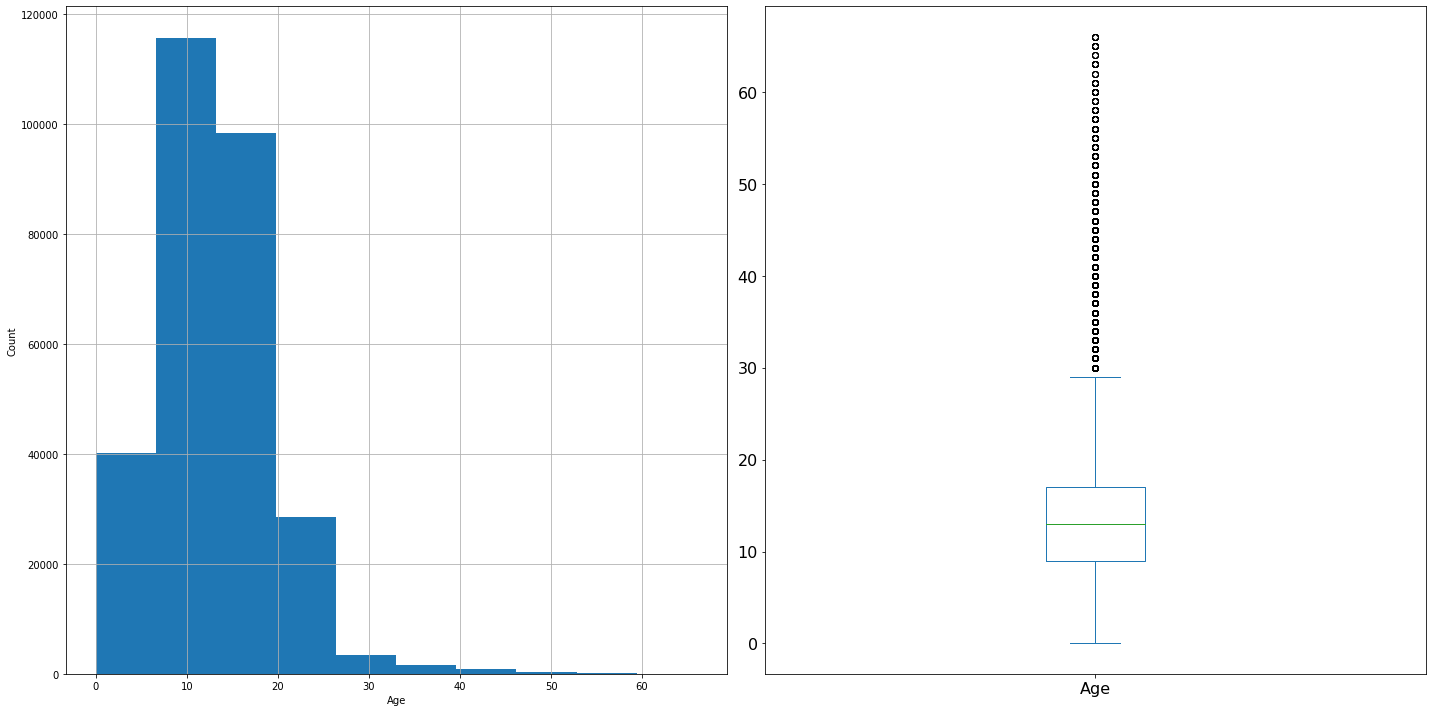

In [41]:
hist_box(df.Age)

In [42]:
df.Age.describe()

count    288936.000000
mean         13.078907
std           6.397929
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          66.000000
Name: Age, dtype: float64

Средний возраст автомобиля равен медианному и соответствует 13 годам. Удалим лишние признаки.

In [43]:
num_features.append("Age")

In [44]:
df = df.drop(["RegistrationMonth","RegistrationYear", "YearCreated", "DateCrawled", "DateCreated", "LastSeen"], axis=1)
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,Age
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,0,66954,5
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,0,90480,12
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,0,91074,15
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,0,60437,8
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,0,33775,21


#### Число фотографий

Может и влияет на цену, но больше характеризует рекламные способности владельца, а не характеристики автомобиля. Точно так же владельца характеризует почтовый код. Теоретически можно по почтовому коду выяснить регион этот регион сделать признаком, но обойдёмся без этого. Удаляем.

In [45]:
df = df.drop(["NumberOfPictures", "PostalCode"], axis=1)
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,5
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,12
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,8
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,21


#### Пробег

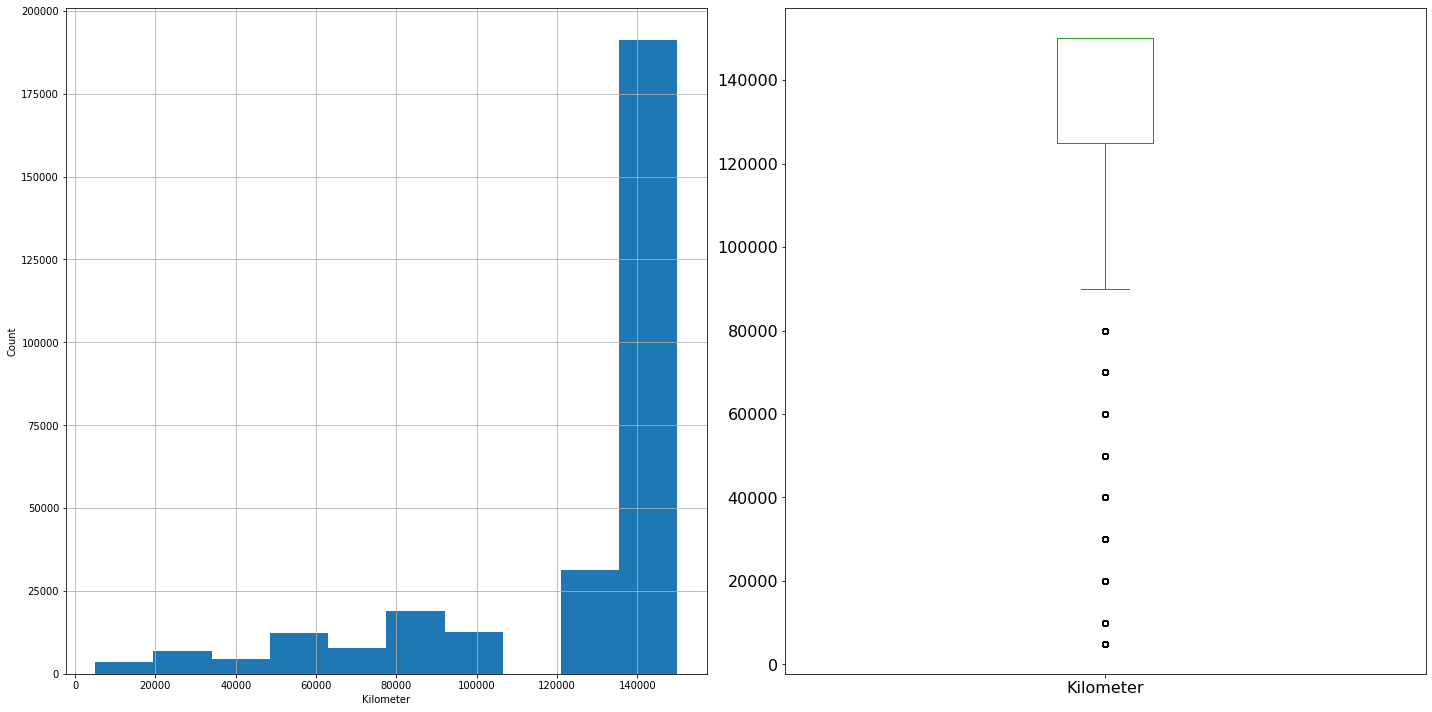

In [46]:
hist_box(df.Kilometer)

Довольно странное распределение. Посмотрим на границы.

In [47]:
df.sort_values(by="Kilometer").head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
350488,12000,small,manual,69,1_reihe,5000,petrol,peugeot,no,0
313648,3400,sedan,manual,75,golf,5000,petrol,volkswagen,no,14
305654,800,small,manual,50,lupo,5000,petrol,volkswagen,yes,17
231989,7500,wagon,manual,231,3er,5000,gasoline,bmw,no,11
8412,19950,bus,auto,180,NaN,5000,petrol,chevrolet,no,25


In [48]:
df.sort_values(by="Kilometer", ascending=False).head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
177166,2100,wagon,manual,75,logan,150000,petrol,dacia,no,8
212481,3500,wagon,manual,136,4_reihe,150000,gasoline,peugeot,no,10
212334,3500,sedan,auto,220,e_klasse,150000,petrol,mercedes_benz,no,23
212335,9999,wagon,manual,170,a3,150000,gasoline,audi,no,8
212337,1800,NaN,manual,136,NaN,150000,gasoline,peugeot,NaN,0


Границы скорее всего обусловлены интерфейсом сайта. Оставляем как есть. Посчитаем описательную статистику.

In [49]:
num_features.append("Kilometer")
df.Kilometer.describe()

count    288936.000000
mean     128313.865354
std       36611.874972
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Определим сколько от начального набора мы потеряли.

In [50]:
100*(INIT_SIZE - df.shape[0])/INIT_SIZE

18.464651253354553

Пятую часть, но данных всё ещё в избытке чтобы обучить модель.

### Анализ и обработка категориальных переменных

Проверим на nan.

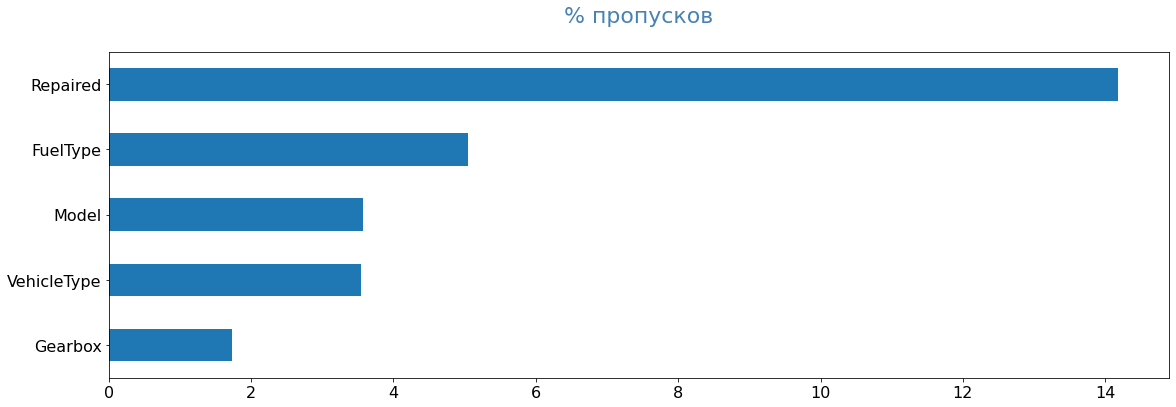

In [51]:
pass_value_barh(df)

% пропусков в категориальных переменных уменьшился после удаления аномалий в числовых.

#### Ремонт

По логике важный показатель. Однако для него невозможно достоверно заполнить пропуски - заполняем значением unkmown.

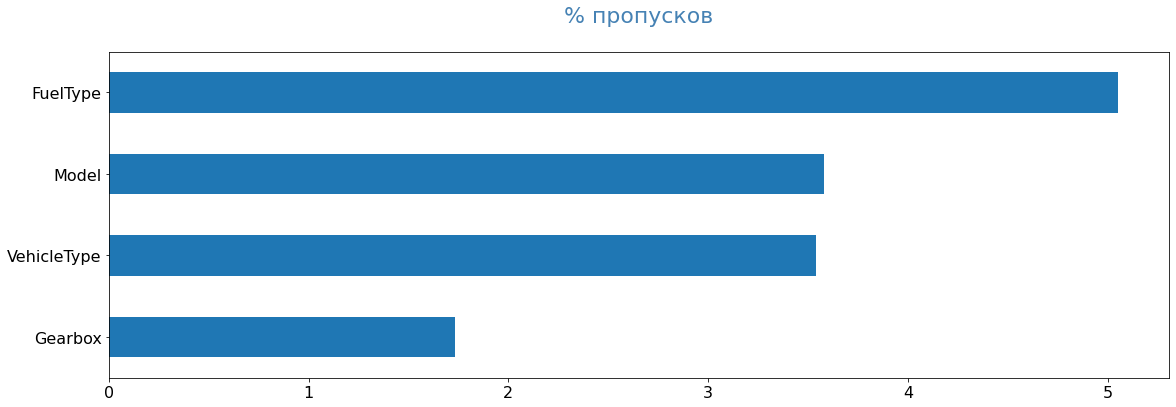

In [52]:
df["Repaired"] = df["Repaired"].fillna("unknown")
pass_value_barh(df)

Визуализируем показатель с помощью круговой диаграммы.

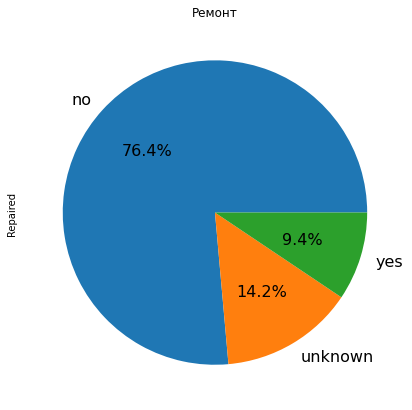

In [53]:
df.Repaired.value_counts().plot(kind='pie', title="Ремонт", fontsize=16, legend=False, autopct='%1.1f%%', figsize=(7,7));

Большинство машин без ремонта, по-крайней мере об этом заявляют продавцы.

Проверим ка мы гипотезу о том что ремонт вляет на среднююю цену.

Используем t-критерий Стьдента для средних независимых выборок.

$H_0$ - средние равны

$H_1$ - средние **НЕ** равны

In [54]:
df_rep = df.query("Repaired == 'yes'")
df_no_rep = df.query("Repaired == 'no'")
results = st.ttest_ind(df_rep.Price,
                       df_no_rep.Price,
                       equal_var = False)
alpha = .05
print(f'Средняя цена:\nРемонт был: {df_rep.Price.mean()}\tРемонта не было: {df_no_rep.Price.mean()}')
print(results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя цена:
Ремонт был: 2202.759057437408	Ремонта не было: 5482.336763440373
0.0
Отвергаем нулевую гипотезу


Средние не равны, причём сильно не равны!

#### Вид топлива

Можно восстановить данные из модели автомобиля, но только примерно, но я считаю, что 3% при таком наборе данных не стоят того. Удаляем. И смотрим на столбчатую диаграмму.

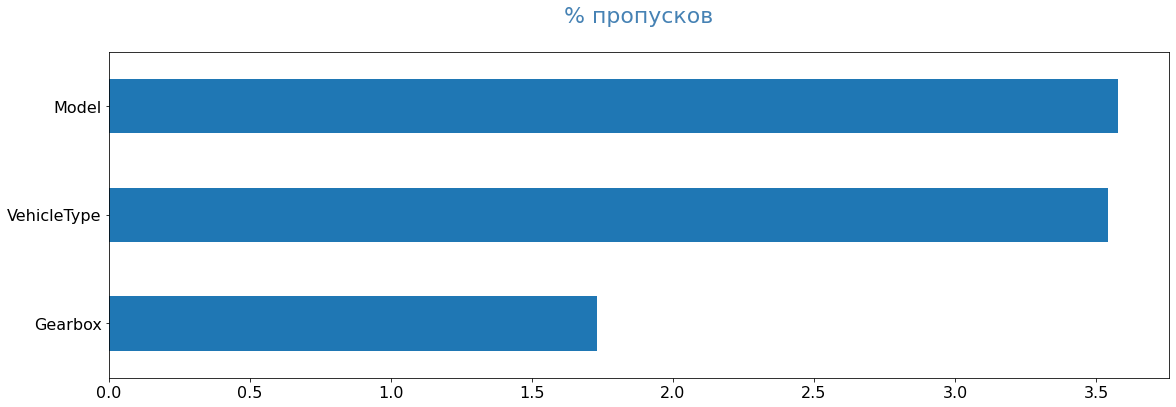

In [55]:
df["FuelType"]= df["FuelType"].fillna("unknown")
pass_value_barh(df)

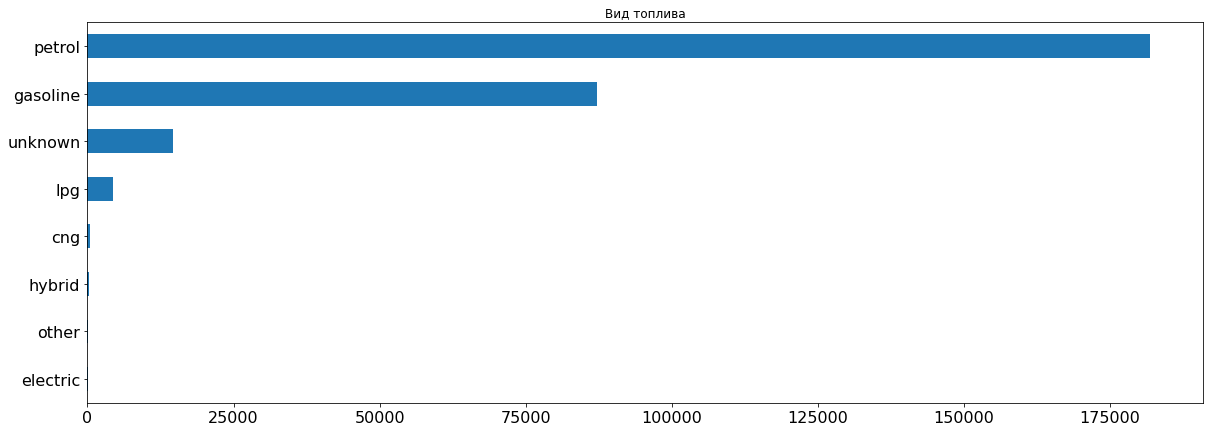

In [56]:
df.FuelType.value_counts().sort_values().plot(kind='barh', title="Вид топлива", fontsize=16, figsize=(20,7));

Первое и второе место занимает бензин и бензин. Что??? Возможно здесь закралась ошибка и имеется вввиду gas oil, а не gasoline? Далее незначительное количество автмобилей на газе, гибридов и электрокаров.

#### Бренд

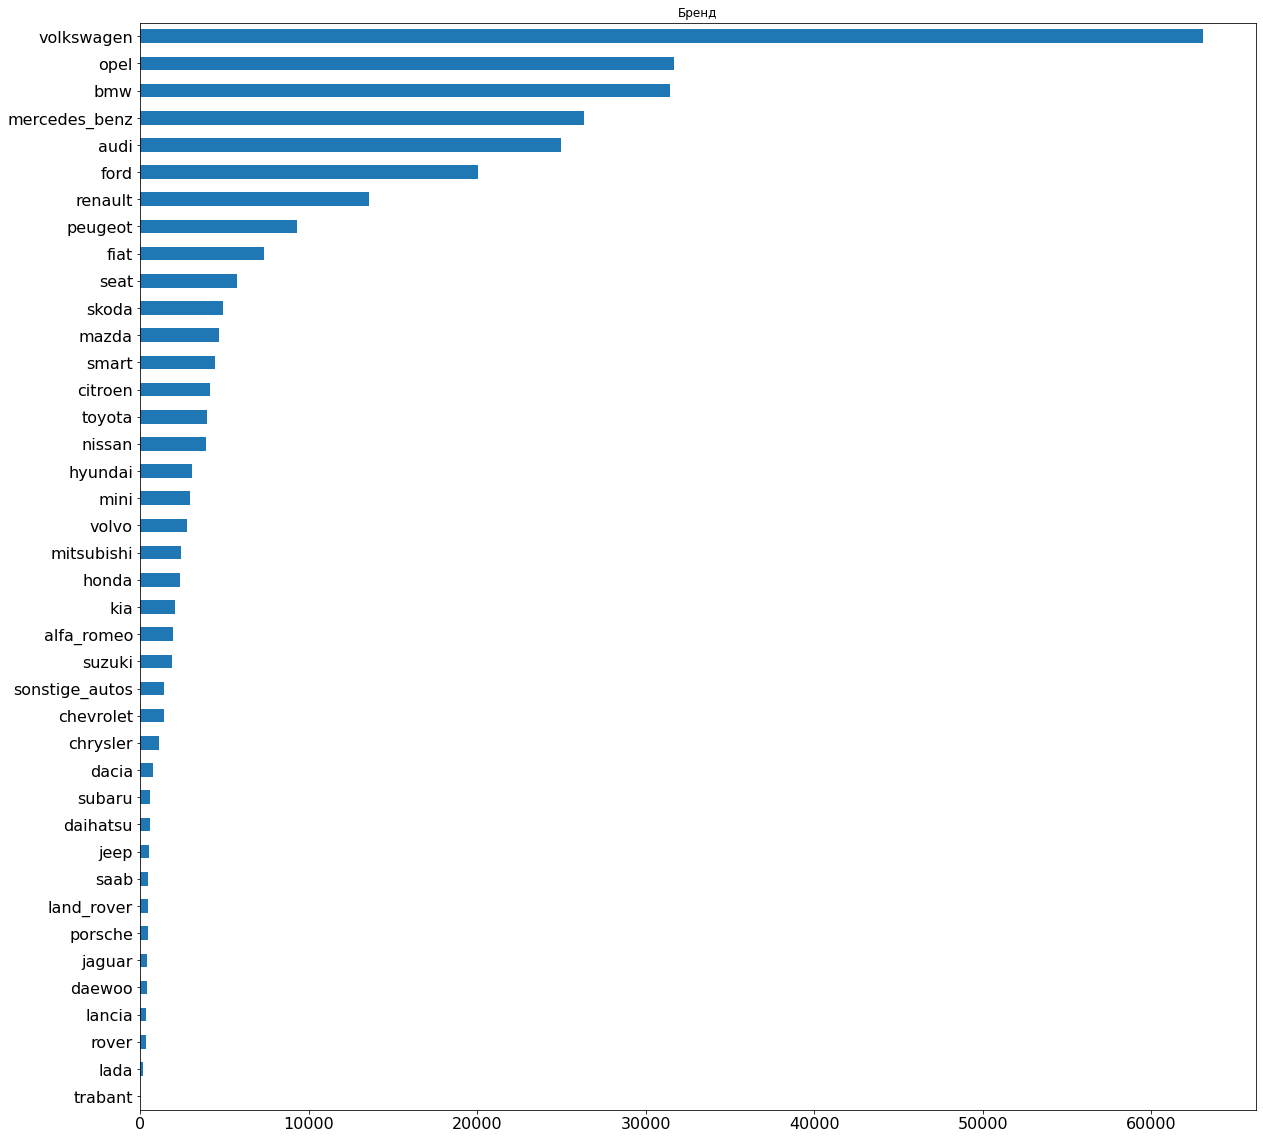

In [57]:
df.Brand.value_counts().sort_values().plot(kind='barh', title="Бренд", fontsize=16, figsize=(20,20));

Бедный OHE, сколько переменных придётся создавать, для некоторых это необходимо.

#### Модель

In [58]:
df.Model.unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', '156', 'escort', 'forester', 'xc_reihe', 'scenic',
       'ka', 'a1', 'focus', 'a4', 'tt', 'astra', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'eos', 'touran', 'getz', 'insignia', 'almera', 'megane',
       'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', 'mustang', '6_reihe',
       'c4', 'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider',
       'cuore', 's_m

Здесь тоже при OHE придётся создавать кучу переменных. Но вот LightGBM умеет напрямую работать с категориальными переменными главное убрать NaN.

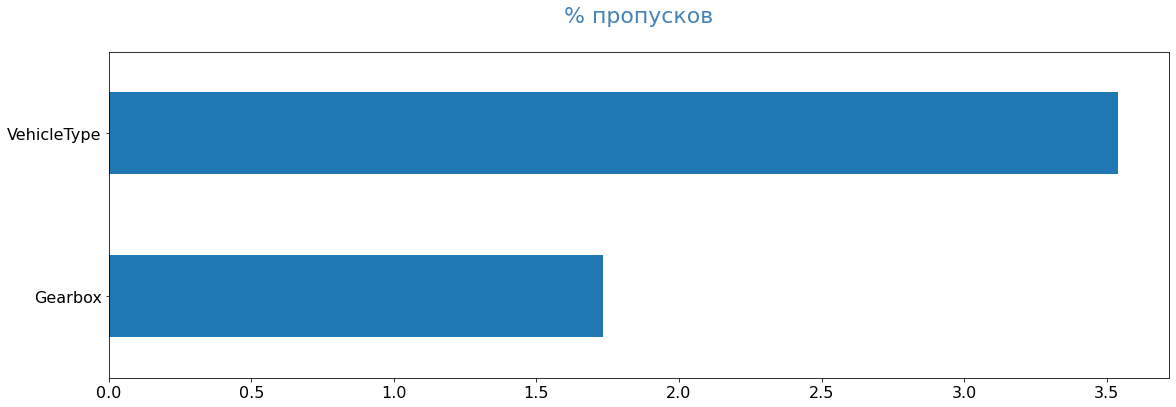

In [59]:
df["Model"] = df["Model"].fillna("unknown")
pass_value_barh(df)

#### Тип кузова

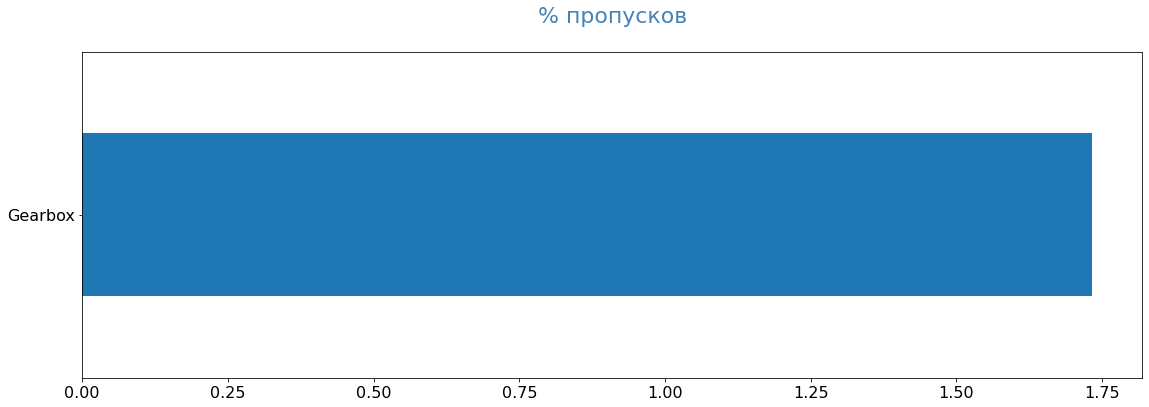

In [60]:
df["VehicleType"] = df["VehicleType"].fillna("unknown")
pass_value_barh(df)

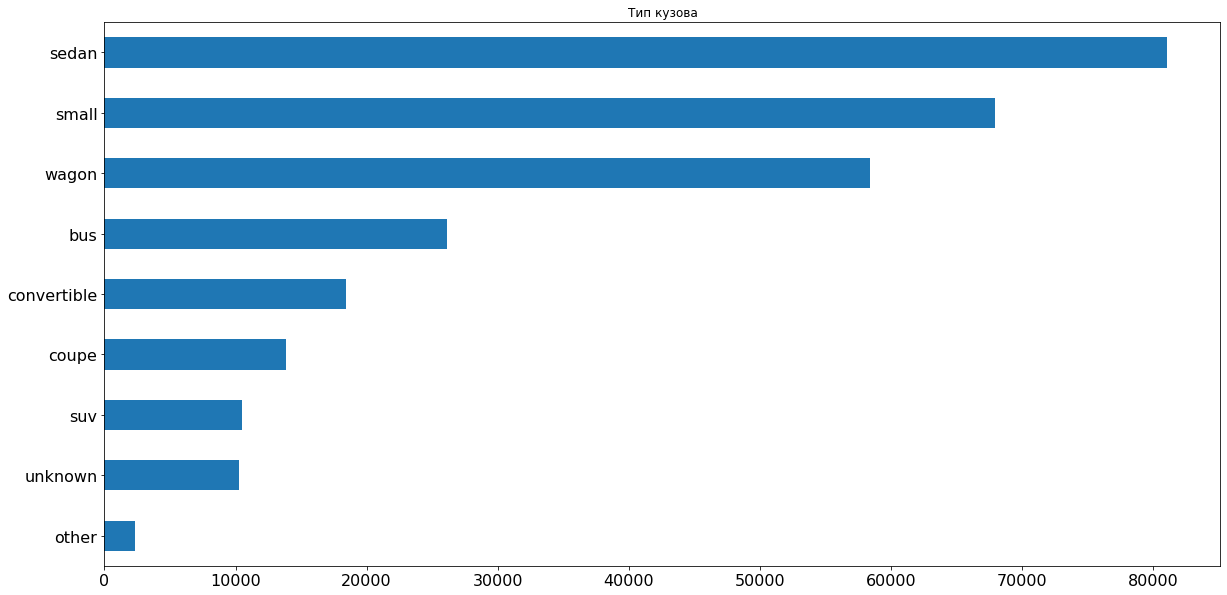

In [62]:
df.VehicleType.value_counts().sort_values().plot(kind='barh', title="Тип кузова", fontsize=16, figsize=(20,10));

#### Тип коробки передач

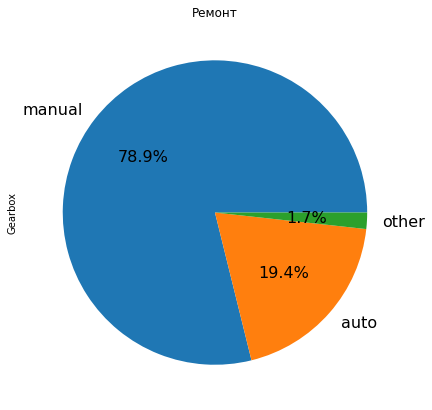

In [63]:
df["Gearbox"] = df["Gearbox"].fillna("other")
df.Gearbox.value_counts().plot(kind='pie', title="Ремонт", fontsize=16, legend=False, autopct='%1.1f%%', figsize=(7,7));

Большинство на механике.

Проверим сколько данных у нас удалено.

In [64]:
100*(INIT_SIZE - df.shape[0])/INIT_SIZE

18.464651253354553

Была удалена, чуть меньше 1/5 набора.

### Корреляции и мультиколинеарность

#### Матрица корреляций

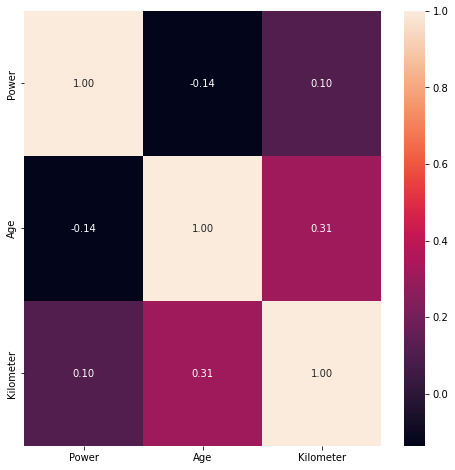

In [65]:
plt.figure(figsize = (8,8))
sns.heatmap(df[num_features].corr(), annot=True, fmt=".2f");

Ожидаемо прямо коррелируют возраст и пробег, однако связь ещё слабая и о серьёзной мультиколинеарности говорить не приходится. Очень слабо коррелируют с отрицательной связью возраст и мощность (прогресс в области ДВС?).

#### Матрица диаграмм рассеяния

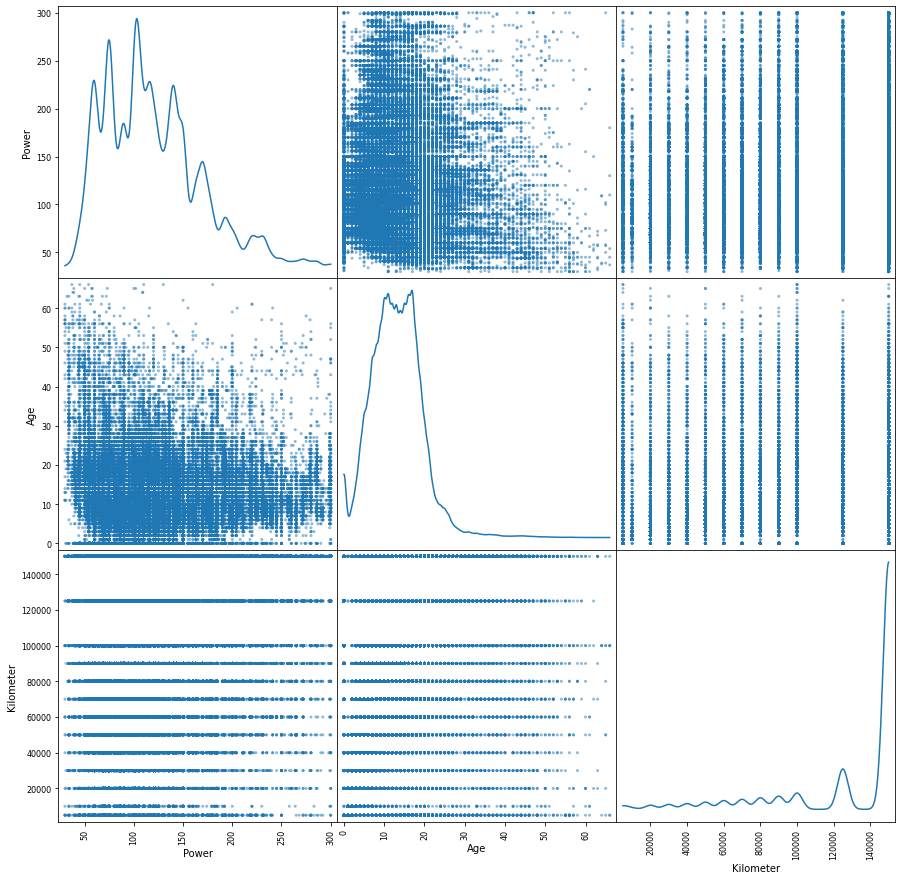

In [67]:
pd.plotting.scatter_matrix(df[num_features], diagonal="kde", figsize=(15, 15));

Во всех трёх переменных прослеживается дискретность данных

## Обучение моделей

В качестве моделей возьмём гребневую регрессию, метод опорных векторов и ансамблевый метод градиентного бустинга. Последнюю модель возьмём из библиотеки LightGBM. Первые две модели требуют OHE-кодирования и стандартизации переменных, а последняя может работать без этих шагов.

### Подготовка набора

Разделим на предикторы и отклик и поделим выборку на тестовую и тренировочную.

In [68]:
SEED = 12345
X = df.drop("Price", axis=1)
y = df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

### Базовая линия

In [69]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_train)
dummy_train_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"RMSE (train) for dummy model = {dummy_train_rmse:.1f}")

RMSE (train) for dummy model = 4548.9


Почти 5000 евро - соответствует СКО для цены.

### Гребневая регрессия

Требует OHE кодирования и шкалирования признаков. Один важный гиперпараметр будем перебирать - степень регуляризации. Воспользуемся Pipline, GridSearchCV, make_scorer.

In [70]:
num_features

['Power', 'Age', 'Kilometer']

In [72]:
cat_features = ["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "Repaired"]

In [73]:
col_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_features), # невозможно применять одновременно ignore c drop='first'
    (StandardScaler(), num_features),
    remainder='passthrough',
#    verbose_feature_names_out=False # в версии пакетов Яндекса ругается на отсутствие этого параметра
)

ridge = Ridge(random_state=SEED)
pipe = Pipeline([("transformer", col_transformer), ("ridge", ridge)])
scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)
cv = KFold(5)
params = {"ridge__alpha":np.logspace(-4, 4, 9)}
gscv_ridge = GridSearchCV(pipe, params, cv=cv, scoring=scorer, verbose=3, n_jobs=-1)

In [74]:
%%time
t0 = time.time()
gscv_ridge.fit(X_train, y_train)
t_ridge_train = time.time() - t0

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 10 s, sys: 8.9 s, total: 18.9 s
Wall time: 12.7 s


In [75]:
best_ridge_cv_rmse = abs(gscv_ridge.best_score_)
best_ridge_alpha = gscv_ridge.best_params_["ridge__alpha"]
best_ridge = gscv_ridge.best_estimator_
print(f"RMSE (cv) for best ridge model = {best_ridge_cv_rmse:.1f} for Alpha = {best_ridge_alpha}")

RMSE (cv) for best ridge model = 2517.8 for Alpha = 1.0


Неплохо. Оставим подробный анализ до следующего пункта.

### LinearSVR

Изначально планировалось взять какое либо нелинейное ядро, однако после первого теста производительности стало ясно, что SVR из sklearn работает крайне медленно с этим набором данных. Было решено использовать метод опорных векторов с линейным ядром: LinearSVR. Будем подбирать параметр регуляризации C, который по смыслу обратен параметру $\alpha$ предыдущей модели.

In [76]:
svr = LinearSVR(max_iter=10000, random_state=SEED)
pipe = Pipeline([("transformer", col_transformer), ("svr", svr)])
params = {"svr__C": np.logspace(-3, 3, 7)}
gscv_svr = GridSearchCV(pipe, params, cv=cv, scoring=scorer, verbose=3, n_jobs=-1)

In [77]:
%%time
t0 = time.time()
gscv_svr.fit(X_train, y_train)
t_svr_train = time.time() - t0


Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: user 7.42 s, sys: 128 ms, total: 7.55 s
Wall time: 13.3 s


In [78]:
best_svr_cv_rmse = abs(gscv_svr.best_score_)
best_svr_c = gscv_svr.best_params_["svr__C"]
best_svr = gscv_svr.best_estimator_
print(f"RMSE (cv) for best svr model = {best_svr_cv_rmse:.1f} for C = {best_svr_c}")

RMSE (cv) for best svr model = 2615.4 for C = 1000.0


Хуже чем у гребневой регрессии.

### Градиентный бустинг

В градиентном бустинге будем подбирать количество листьев в дереве и скорость обучения. Число деревьев оставим по умолчанию - 100. Модель не требует OHE (можно использовать простое кодирование).

In [79]:
gb = LGBMRegressor(random_state=SEED)
col_transformer = make_column_transformer(
    (OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value=-1), cat_features), # невозможно применять одновременно ignore c drop='first'
    remainder='passthrough',
#    verbose_feature_names_out=False # в версии пакетов Яндекса ругается на отсутствие этого параметра
)

pipe = Pipeline([("transformer", col_transformer), ("gb", gb)])
params = {"gb__num_leaves":[20, 30, 40], 'gb__learning_rate':[0.01, 0.1, 1.0]}
gscv_gb = GridSearchCV(pipe, params, cv=cv, scoring=scorer, verbose=3, n_jobs=-1)

In [80]:
%%time
t0 = time.time()
gscv_gb.fit(X_train, y_train)
t_gb_train = time.time() - t0

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 21.6 s, sys: 226 ms, total: 21.8 s
Wall time: 15.8 s


In [81]:
best_gb_cv_rmse = abs(gscv_gb.best_score_)
best_gb_nl = gscv_gb.best_params_["gb__num_leaves"]
best_gb_lr = gscv_gb.best_params_["gb__learning_rate"]
best_gb = gscv_gb.best_estimator_
print(f"RMSE (cv) for best GB model = {best_gb_cv_rmse:.1f} for No. leaves = {best_gb_nl}, Learning Rate = {best_gb_lr}")

RMSE (cv) for best GB model = 1615.4 for No. leaves = 40, Learning Rate = 0.1


Очень хорошо по сравнению с другими моделями.

## Анализ моделей

### Оценка при кросс-валидации

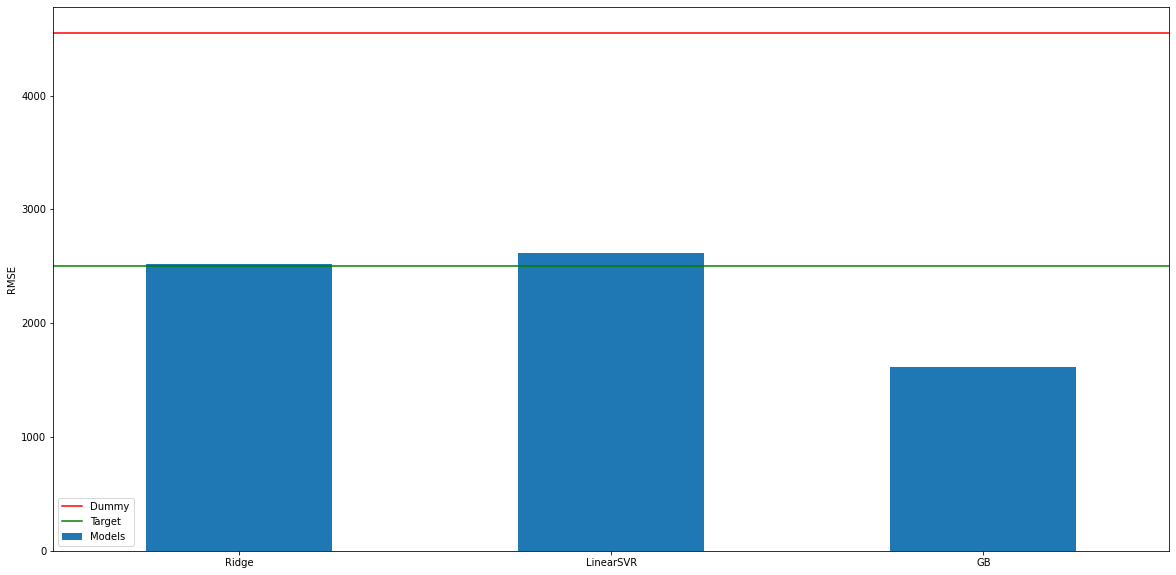

In [82]:
cv_result = pd.Series(data=[best_ridge_cv_rmse, best_svr_cv_rmse, best_gb_cv_rmse], index=["Ridge", "LinearSVR", "GB"], name="Models")
fig, ax = plt.subplots(1, 1,figsize=(20, 10));
ax.set_ylabel("RMSE")
cv_result.plot.bar(ax=ax, rot=0);

ax.axhline(dummy_train_rmse, c="r", label="Dummy");
ax.axhline(2500, c="g", label="Target");
ax.legend();

Абсолютный победитель - Градиентный Бустинг. Второе место у простой модели гребневой регрессмм.

### Время подбора гиперпараметров и обучения

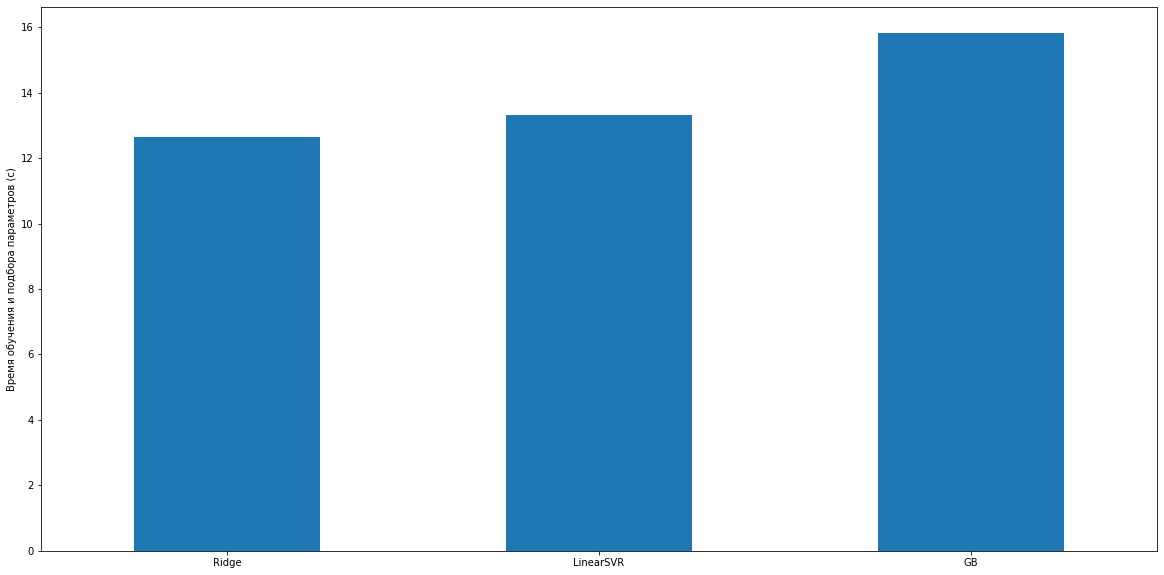

In [83]:
cv_time = pd.Series(data=[t_ridge_train, t_svr_train, t_gb_train], index=["Ridge", "LinearSVR", "GB"], name="Models")
fig, ax = plt.subplots(1, 1,figsize=(20, 10));
ax.set_ylabel("Время обучения и подбора параметров (с)")
cv_time.plot.bar(ax=ax, rot=0);

На первом месте гребневая регрессия.

### Время обучения без подбора гипермараметров.

In [84]:
%%time
t0 = time.time()
best_ridge.fit(X_train, y_train)
t_ridge_train = time.time() - t0

CPU times: user 6.55 s, sys: 8.45 s, total: 15 s
Wall time: 1.79 s


In [85]:
%%time
t0 = time.time()
best_svr.fit(X_train, y_train)
t_svr_train = time.time() - t0

CPU times: user 4.99 s, sys: 31.6 ms, total: 5.02 s
Wall time: 5.02 s


In [86]:
%%time
t0 = time.time()
best_gb.fit(X_train, y_train)
t_gb_train = time.time() - t0

CPU times: user 30.5 s, sys: 117 ms, total: 30.6 s
Wall time: 3.22 s


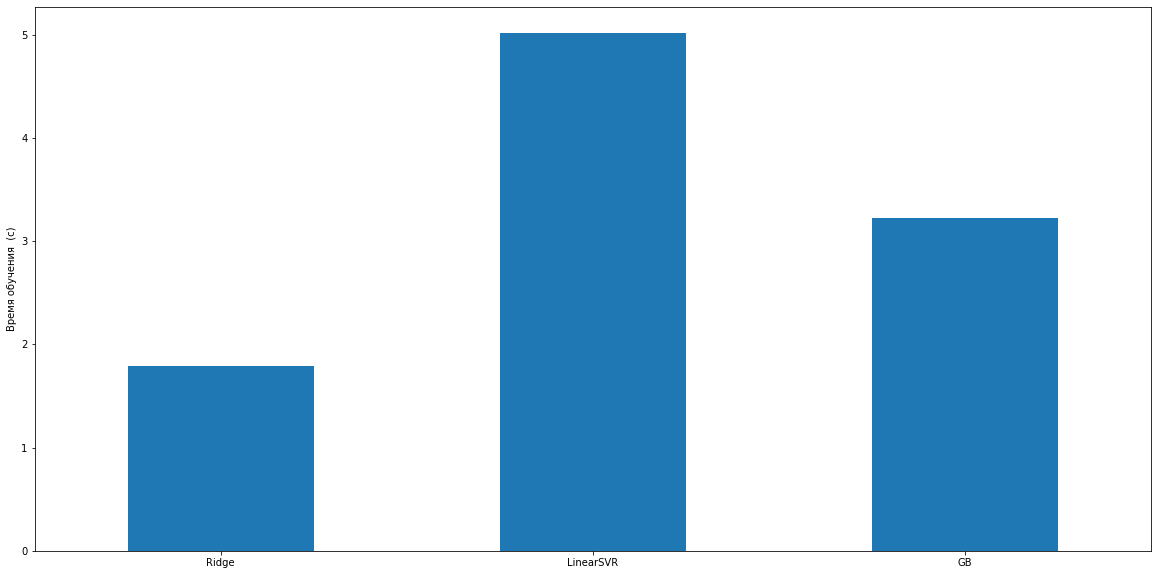

In [87]:
cv_time = pd.Series(data=[t_ridge_train, t_svr_train, t_gb_train], index=["Ridge", "LinearSVR", "GB"], name="Models")
fig, ax = plt.subplots(1, 1,figsize=(20, 10));
ax.set_ylabel("Время обучения  (с)")
cv_time.plot.bar(ax=ax, rot=0);

Гребневая регрессия впереди, медленнее - градиентный бустинг, но по качеству предсказания она далеко впереди.

### Оценка на тестовом наборе

In [88]:
y_pred = dummy.predict(X_test)
dummy_test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (test) for dummy model = {dummy_test_rmse:.1f}")

RMSE (test) for dummy model = 4558.2


In [89]:
%%time
y_pred = best_gb.predict(X_test)

CPU times: user 792 ms, sys: 1.03 ms, total: 793 ms
Wall time: 174 ms


In [90]:
gb_test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (test) for GB model = {gb_test_rmse:.1f}")

RMSE (test) for GB model = 1620.1


Оценка лучшей модели незначительно ухудшилась, однако это не критично.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей